# Convolutional Neural Networks

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Configuración básica para trabajar con el dataset de coches
print("Importaciones listas y configuradas para clasificar coches.")


Importaciones listas y configuradas para clasificar coches.


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import SGD

# Configuración para redes neuronales con TensorFlow y Keras
print("Versión de TensorFlow:", tf.__version__)
print("Keras está integrado con TensorFlow.")
print("Configuración lista para trabajar con TensorFlow y Keras.")


Versión de TensorFlow: 2.18.0
Keras está integrado con TensorFlow.
Configuración lista para trabajar con TensorFlow y Keras.


In [3]:
from PIL import Image
import os

# Ruta original y nueva para las imágenes
source_path = r"./carros" 
destination_path = r"./imgs_reajustado"

# Tamaño deseado de las imágenes
target_size = (150, 150)  # Cambiar el tamaño a 150x150

# Crear carpeta de destino si no existe
os.makedirs(destination_path, exist_ok=True)

# Procesar cada subcarpeta en la carpeta de origen
for class_name in os.listdir(source_path):
    class_path = os.path.join(source_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # Crear directorio para cada clase en la carpeta de destino
    output_class_path = os.path.join(destination_path, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    # Redimensionar y mover imágenes
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                # Convertir a RGB (por si hay imágenes en otro modo como escala de grises)
                img = img.convert("RGB")
                # Redimensionar y guardar
                img_resized = img.resize(target_size)
                img_resized.save(os.path.join(output_class_path, img_name))
        except Exception as e:
            print(f"Error al procesar {img_path}: {e}")


# Cargar set de Imágenes

In [4]:
import os
import re  # Importar el módulo de expresiones regulares
import matplotlib.pyplot as plt

dirname = os.path.join(os.getcwd(), './imgs_reajustado')  # Cambiar ruta a imgs_reajustado
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot = ''
cant = 0

print("Leyendo imágenes de ", imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", filename):  # Verificar extensión
            cant += 1
            filepath = os.path.join(root, filename)
            try:
                # Leer la imagen y verificar si es válida
                image = plt.imread(filepath)
                if len(image.shape) == 3:  # Verificar que la imagen sea RGB
                    images.append(image)
            except Exception as e:
                print(f"Error al leer la imagen {filepath}: {e}")
            
            # Mostrar el progreso en consola
            b = f"Leyendo... {cant}"
            print(b, end="\r")
            
            # Actualizar información del directorio
            if prevRoot != root:
                print(root, cant)
                prevRoot = root
                directories.append(root)  # Guardar el nombre del directorio
                dircount.append(cant)
                cant = 0

dircount.append(cant)

# Ajustar la cuenta de imágenes por directorio
dircount = dircount[1:]
dircount[0] = dircount[0] + 1

print('Directorios leídos:', len(directories))
print("Imágenes en cada directorio:", dircount)
print('Suma total de imágenes en subdirs:', sum(dircount))


Leyendo imágenes de  c:\Users\anava\Desktop\IA 2024\Repositorio\proyecto33\./imgs_reajustado\
c:\Users\anava\Desktop\IA 2024\Repositorio\proyecto33\./imgs_reajustado\cybertruck 1
c:\Users\anava\Desktop\IA 2024\Repositorio\proyecto33\./imgs_reajustado\ferrari 10000
c:\Users\anava\Desktop\IA 2024\Repositorio\proyecto33\./imgs_reajustado\lincoln 10820
c:\Users\anava\Desktop\IA 2024\Repositorio\proyecto33\./imgs_reajustado\mazda 10000
c:\Users\anava\Desktop\IA 2024\Repositorio\proyecto33\./imgs_reajustado\mercedez 10866
Directorios leídos: 5
Imágenes en cada directorio: [10001, 10820, 10000, 10866, 9999]
Suma total de imágenes en subdirs: 51686


# Creamos las etiquetas

In [5]:
labels = []
indice = 0

# Generar las etiquetas basadas en el conteo de imágenes por directorio
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)  # Asignar la etiqueta correspondiente al índice del directorio
    indice += 1

print("Cantidad de etiquetas creadas: ", len(labels))


Cantidad de etiquetas creadas:  51686


In [6]:
carros = []  # Lista para almacenar los nombres de las clases
indice = 0

# Extraer los nombres de los directorios como clases
for directorio in directories:
    name = os.path.basename(directorio)  # Extraer el nombre del directorio directamente
    print(indice, name)  # Imprimir índice y nombre del directorio
    carros.append(name)  # Agregar el nombre del directorio a la lista
    indice += 1


0 cybertruck
1 ferrari
2 lincoln
3 mazda
4 mercedez


In [7]:
from skimage.transform import resize

# Definir el tamaño esperado para las imágenes (150 x 150 x 3)
expected_shape = (150, 150, 3)  # Cambiar al tamaño que espera el modelo

# Validar y redimensionar imágenes cargadas desde imgs_reajustado
validated_images = []
for img in images:
    if img.shape != expected_shape:  # Verificar si la imagen no tiene el tamaño esperado
        resized_img = resize(
            img, expected_shape, anti_aliasing=True, preserve_range=True
        ).astype(np.uint8)  # Redimensionar y convertir a uint8
        validated_images.append(resized_img)
    else:
        validated_images.append(img)  # Agregar sin cambios si ya tiene el tamaño esperado

# Convertir etiquetas y datos a arreglos de NumPy
y = np.array(labels)  # Etiquetas como array de NumPy
X = np.array(validated_images, dtype=np.uint8)  # Convertir imágenes de lista a array de NumPy

# Identificar las clases únicas y contar cuántas hay
classes = np.unique(y)  # Clases únicas en las etiquetas
nClasses = len(classes)  # Número total de clases

# Verificar que el tamaño del conjunto coincida con las imágenes cargadas
assert X.shape[0] == y.shape[0], "El número de imágenes y etiquetas no coincide."

# Imprimir información del conjunto de datos
print('Número total de clases:', nClasses)
print('Clases únicas:', classes)
print('Tamaño del conjunto de datos (imágenes, altura, ancho, canales):', X.shape)


Número total de clases: 5
Clases únicas: [0 1 2 3 4]
Tamaño del conjunto de datos (imágenes, altura, ancho, canales): (51686, 150, 150, 3)


# Creamos Sets de Entrenamiento y Test

In [8]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar las formas de los conjuntos de datos
print('Forma de los datos de entrenamiento:', train_X.shape, train_Y.shape)
print('Forma de los datos de prueba:', test_X.shape, test_Y.shape)


Forma de los datos de entrenamiento: (41348, 150, 150, 3) (41348,)
Forma de los datos de prueba: (10338, 150, 150, 3) (10338,)


Text(0.5, 1.0, 'Etiqueta Real: mazda')

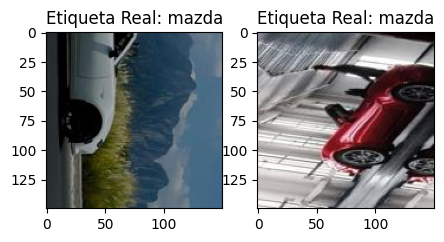

In [9]:
# Asegúrate de que las etiquetas estén disponibles
car_labels = ["cybertruck", "ferrari", "lincoln", "mazda", "mercedez"]

plt.figure(figsize=[5, 5])

# Mostrar la primera imagen en el conjunto de entrenamiento
plt.subplot(121)
plt.imshow(train_X[0].astype(np.uint8))  # Asegurarse de mostrar la imagen correctamente
train_label_index = train_Y[0]  # Directamente la etiqueta numérica
plt.title(f"Etiqueta Real: {car_labels[train_label_index]}")

# Mostrar la primera imagen en el conjunto de prueba
plt.subplot(122)
plt.imshow(test_X[0].astype(np.uint8))  # Asegurarse de mostrar la imagen correctamente
test_label_index = test_Y[0]  # Directamente la etiqueta numérica
plt.title(f"Etiqueta Real: {car_labels[test_label_index]}")


# Preprocesamos las imagenes

Forma de train_X: (41348, 150, 150, 3)
Forma de test_X: (10338, 150, 150, 3)


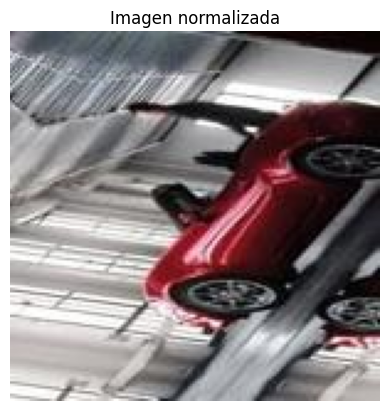

In [10]:
# Convertir las imágenes a tipo float32 y normalizarlas
train_X = train_X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

# Verificar las formas de los datos de entrenamiento y prueba
print("Forma de train_X:", train_X.shape)
print("Forma de test_X:", test_X.shape)

# Mostrar una imagen normalizada del conjunto de prueba
plt.imshow(test_X[0])  # No necesitas reconvertir, matplotlib admite imágenes en [0, 1]
plt.title("Imagen normalizada")
plt.axis("off")
plt.show()


## Hacemos el One-hot Encoding para la red

In [11]:
from tensorflow.keras.utils import to_categorical  # Importar la función

# Verificar el número de clases
print("Número de clases (nClasses):", nClasses)

# Cambiar las etiquetas a codificación one-hot
train_Y_one_hot = to_categorical(train_Y, num_classes=nClasses)
test_Y_one_hot = to_categorical(test_Y, num_classes=nClasses)

# Verificar las formas de las etiquetas después de la codificación
print("Forma de train_Y_one_hot:", train_Y_one_hot.shape)
print("Forma de test_Y_one_hot:", test_Y_one_hot.shape)

# Mostrar la transformación de una etiqueta a one-hot encoding
print('Etiqueta original:', train_Y[0])
print('Después de la conversión a one-hot:', train_Y_one_hot[0])


Número de clases (nClasses): 5
Forma de train_Y_one_hot: (41348, 5)
Forma de test_Y_one_hot: (10338, 5)
Etiqueta original: 3
Después de la conversión a one-hot: [0. 0. 0. 1. 0.]


# Creamos el Set de Entrenamiento y Validación

In [12]:
# Mezclar todo y crear los grupos de entrenamiento y validación
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)


In [13]:
# Mostrar las formas finales de los conjuntos de datos
print("Forma de los datos de entrenamiento:", train_X.shape)
print("Forma de los datos de validación:", valid_X.shape)
print("Forma de los datos de prueba:", test_X.shape)
print("Forma de las etiquetas de entrenamiento:", train_label.shape)
print("Forma de las etiquetas de validación:", valid_label.shape)
print("Forma de las etiquetas de prueba:", test_Y_one_hot.shape)


Forma de los datos de entrenamiento: (33078, 150, 150, 3)
Forma de los datos de validación: (8270, 150, 150, 3)
Forma de los datos de prueba: (10338, 150, 150, 3)
Forma de las etiquetas de entrenamiento: (33078, 5)
Forma de las etiquetas de validación: (8270, 5)
Forma de las etiquetas de prueba: (10338, 5)


# Creamos el modelo de CNN

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Declarar las variables con los parámetros de configuración de la red
INIT_LR = 1e-3  # Tasa de aprendizaje inicial ajustada para velocidad y estabilidad
epochs = 50  # Reducido a 40 para limitar el tiempo de entrenamiento
batch_size = 128  # Tamaño de lote eficiente para memoria y rendimiento

# Callback para detener el entrenamiento si no mejora
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Detiene si no mejora en 5 épocas consecutivas
    restore_best_weights=True
)

# Callback para reducir el learning rate si la validación no mejora
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce el learning rate a la mitad
    patience=3,  # Espera 3 épocas sin mejora






    
    min_lr=1e-6  # Learning rate mínimo
)

# Mostrar los parámetros configurados
print(f"Tasa de aprendizaje inicial: {INIT_LR}")
print(f"Número de épocas: {epochs}")
print(f"Tamaño de batch: {batch_size}")


Tasa de aprendizaje inicial: 0.001
Número de épocas: 50
Tamaño de batch: 128


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, LeakyReLU

# Definir el modelo de la red neuronal convolucional
car_model = Sequential()

# Primera capa convolucional
car_model.add(Conv2D(32, kernel_size=(5, 5), padding='same', input_shape=(150, 150, 3)))
car_model.add(BatchNormalization())
car_model.add(LeakyReLU())  # Sin alpha (por defecto es 0.3)
car_model.add(MaxPooling2D((2, 2), padding='same'))
car_model.add(Dropout(0.25))

# Segunda capa convolucional
car_model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
car_model.add(BatchNormalization())
car_model.add(LeakyReLU())
car_model.add(MaxPooling2D((2, 2), padding='same'))
car_model.add(Dropout(0.25))

# Tercera capa convolucional
car_model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
car_model.add(BatchNormalization())
car_model.add(LeakyReLU())
car_model.add(MaxPooling2D((2, 2), padding='same'))
car_model.add(Dropout(0.4))

# Cuarta capa convolucional
car_model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
car_model.add(BatchNormalization())
car_model.add(LeakyReLU())
car_model.add(MaxPooling2D((2, 2), padding='same'))
car_model.add(Dropout(0.5))

# Aplanar para pasar a capas densas
car_model.add(Flatten())

# Primera capa densa
car_model.add(Dense(512))
car_model.add(BatchNormalization())
car_model.add(LeakyReLU())
car_model.add(Dropout(0.5))

# Segunda capa densa
car_model.add(Dense(128))
car_model.add(BatchNormalization())
car_model.add(LeakyReLU())
car_model.add(Dropout(0.5))

# Capa de salida
car_model.add(Dense(nClasses, activation='softmax'))

# Mostrar la arquitectura del modelo
car_model.summary()


c:\Users\anava\Desktop\IA 2024\Repositorio\proyecto33\nuevo_entorno\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 13,568,453 (51.76 MB)

 Trainable params: 13,566,213 (51.75 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [16]:
# Resumen de la arquitectura del modelo
car_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 13,568,453 (51.76 MB)

 Trainable params: 13,566,213 (51.75 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [17]:
import tensorflow as tf  # Importar TensorFlow

# Compilar el modelo con una función de pérdida, un optimizador y una métrica
car_model.compile(
    loss='categorical_crossentropy',  # Pérdida categórica cruzada para clasificación multiclase
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),  # Optimizador Adam con tasa de aprendizaje inicial
    metrics=['accuracy']  # Métrica de precisión para evaluar el desempeño
)

print("Modelo compilado con éxito.")


Modelo compilado con éxito.


# Entrenamos el modelo: Aprende a clasificar imágenes

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Definir callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Detener si no mejora después de 5 épocas
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_car_model.keras',  # Cambiar extensión a .keras para TF >= 2.11
    monitor='val_loss', 
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,  # Reducir la tasa de aprendizaje en un factor de 0.2
    patience=3,  # Reducir si no mejora en 3 épocas
    min_lr=1e-6  # Tasa de aprendizaje mínima
)

# Entrenar el modelo
car_train = car_model.fit(
    train_X, train_label,               # Conjunto de entrenamiento (imágenes y etiquetas one-hot)
    batch_size=batch_size,              # Tamaño de lote
    epochs=epochs,                      # Número de épocas
    verbose=1,                          # Nivel de detalle en la salida
    validation_data=(valid_X, valid_label),  # Conjunto de validación
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Añadir callbacks
)

print("Entrenamiento completado.")


Epoch 1/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.4697 - loss: 1.3471 - val_accuracy: 0.2688 - val_loss: 2.2150 - learning_rate: 0.0010
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.6331 - loss: 0.9267 - val_accuracy: 0.5960 - val_loss: 1.0275 - learning_rate: 0.0010
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.6943 - loss: 0.7802 - val_accuracy: 0.7010 - val_loss: 0.7521 - learning_rate: 0.0010
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.7325 - loss: 0.6941 - val_accuracy: 0.7576 - val_loss: 0.6344 - learning_rate: 0.0010
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.7580 - loss: 0.6363 - val_accuracy: 0.6989 - val_loss: 0.8114 - learning_rate: 0.0010
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step - accuracy: 0.7866 - loss: 0.5727 - val_accuracy: 0.7676 - val_loss: 0.6521 - learning_rate: 0.0010
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.7994 - loss: 0.

In [19]:
# Guardar el modelo final entrenado para uso futuro
car_model.save("car_classifier_final.h5")
print("Modelo final guardado como 'car_classifier_final.h5'.")


Modelo final guardado como 'car_classifier_final.h5'.


# Evaluamos la red

In [20]:
# Evaluar el modelo en el conjunto de prueba
test_eval = car_model.evaluate(test_X, test_Y_one_hot, verbose=1)

# Mostrar la pérdida y la precisión del modelo en el conjunto de prueba
print("Pérdida en el conjunto de prueba:", test_eval[0])
print("Precisión en el conjunto de prueba:", test_eval[1])


324/324 ━━━━━━━━━━━━━━━━━━━━ 46s 141ms/step - accuracy: 0.8635 - loss: 0.3469
Pérdida en el conjunto de prueba: 0.35366857051849365
Precisión en el conjunto de prueba: 0.8626427054405212


In [21]:
# Mostrar los resultados de pérdida y precisión en el conjunto de prueba
print('Pérdida en el conjunto de prueba:', test_eval[0])
print('Precisión en el conjunto de prueba:', test_eval[1])


Pérdida en el conjunto de prueba: 0.35366857051849365
Precisión en el conjunto de prueba: 0.8626427054405212


In [22]:
# Historial del entrenamiento
print("Historial del entrenamiento:")
print(car_train.history)


Historial del entrenamiento:
{'accuracy': [0.5359151363372803, 0.64895099401474, 0.7032166123390198, 0.7368341684341431, 0.7634984254837036, 0.7850534915924072, 0.8002902269363403, 0.8397122025489807, 0.850323498249054, 0.8560070395469666, 0.8630812168121338, 0.8681298494338989, 0.8776226043701172, 0.8807364702224731, 0.8843944668769836, 0.8849083781242371, 0.8862083554267883, 0.8882036209106445], 'loss': [1.1564034223556519, 0.883206844329834, 0.7627890706062317, 0.6812387108802795, 0.6236056089401245, 0.5718021392822266, 0.5294657349586487, 0.43556979298591614, 0.4098024368286133, 0.3934319019317627, 0.37324586510658264, 0.3624532222747803, 0.33709123730659485, 0.32556024193763733, 0.322467178106308, 0.3163362741470337, 0.3103790879249573, 0.30694469809532166], 'val_accuracy': [0.2688029110431671, 0.5960096716880798, 0.7009673714637756, 0.7575574517250061, 0.698911726474762, 0.7675937414169312, 0.769286572933197, 0.8201934695243835, 0.8541716933250427, 0.8413543105125427, 0.830108821

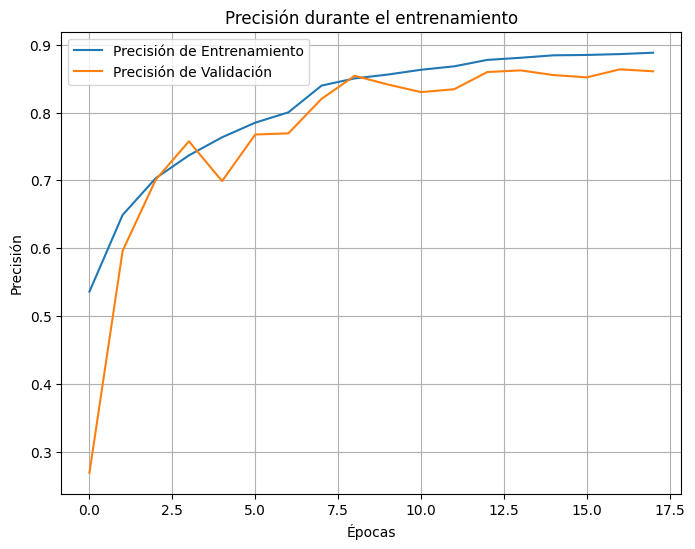

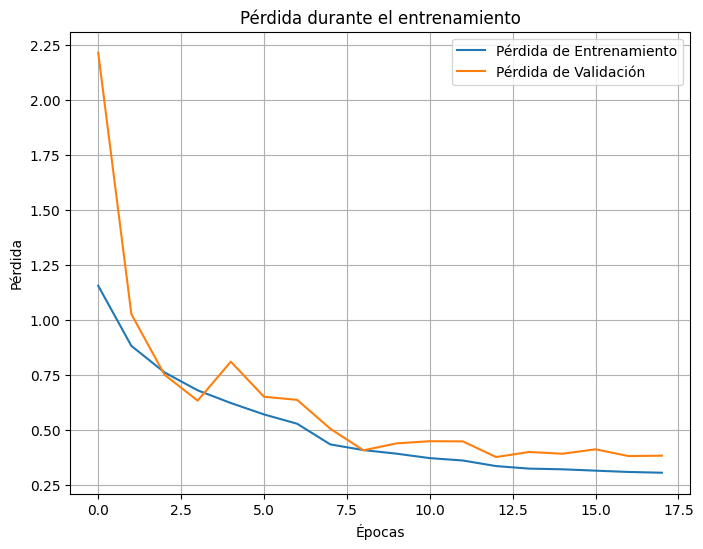

In [23]:
# Extraer métricas del historial de entrenamiento
accuracy = car_train.history['accuracy']
val_accuracy = car_train.history['val_accuracy']
loss = car_train.history['loss']
val_loss = car_train.history['val_loss']

# Graficar precisión
plt.figure(figsize=(8, 6))
plt.plot(range(len(accuracy)), accuracy, label='Precisión de Entrenamiento')
plt.plot(range(len(val_accuracy)), val_accuracy, label='Precisión de Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

# Graficar pérdida
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss)), loss, label='Pérdida de Entrenamiento')
plt.plot(range(len(val_loss)), val_loss, label='Pérdida de Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()


In [24]:
# Hacer predicciones en el conjunto de prueba
predicted_classes2 = car_model.predict(test_X)

# Mostrar la forma del array de predicciones
print("Forma del array de predicciones:", predicted_classes2.shape)


324/324 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step
Forma del array de predicciones: (10338, 5)


In [25]:
# Convertir las probabilidades en clases predichas
predicted_classes = []
for predicted_car in predicted_classes2:
    predicted_classes.append(predicted_car.tolist().index(max(predicted_car)))
predicted_classes = np.array(predicted_classes)

# Mostrar las primeras predicciones
print("Primeras clases predichas:", predicted_classes[:10])


Primeras clases predichas: [3 1 1 2 2 3 3 2 4 2]


In [26]:
print("Forma de las clases predichas:", predicted_classes.shape)
print("Forma de las etiquetas reales:", test_Y.shape)


Forma de las clases predichas: (10338,)
Forma de las etiquetas reales: (10338,)


# Aprendamos de los errores: Qué mejorar

Predicciones correctas: 8918 de 10338


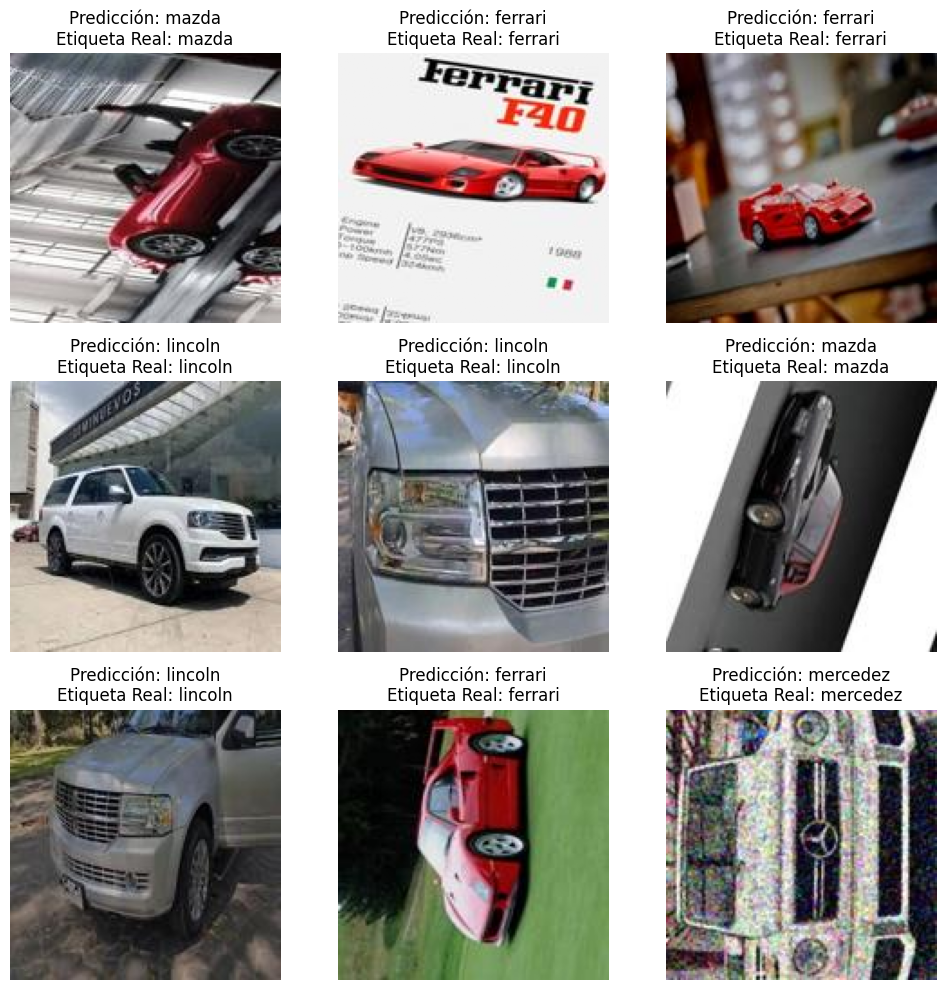

In [27]:
# Convertir etiquetas reales de one-hot a índices
true_classes = np.argmax(test_Y_one_hot, axis=1)

# Verificar las predicciones correctas
correct = np.where(predicted_classes == true_classes)[0]
print(f"Predicciones correctas: {len(correct)} de {len(true_classes)}")

# Mostrar las primeras imágenes correctamente clasificadas
plt.figure(figsize=(10, 10))
for i, idx in enumerate(correct[:9]):  # Mostrar las primeras 9 imágenes correctamente clasificadas
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_X[idx])  # Mostrar la imagen
    plt.title(f"Predicción: {carros[predicted_classes[idx]]}\nEtiqueta Real: {carros[true_classes[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Predicciones incorrectas: 1420 de 10338


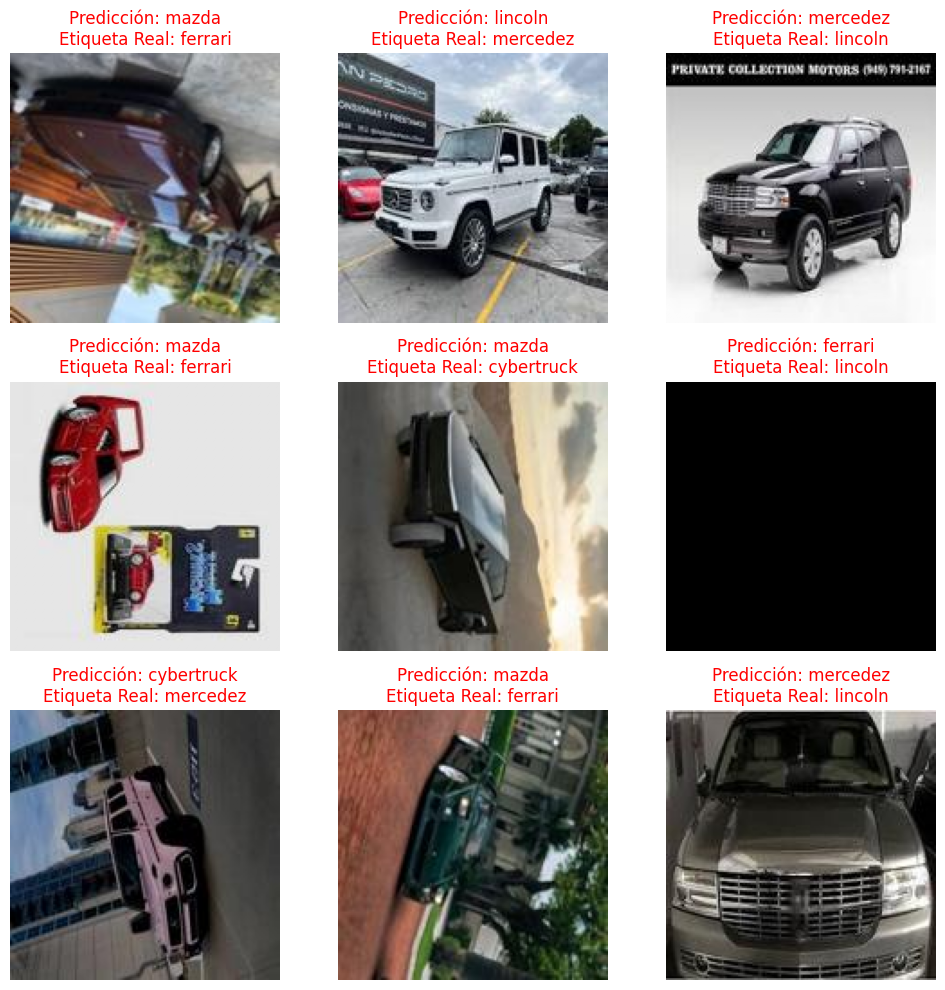

In [28]:
# Convertir etiquetas reales de one-hot a índices
true_classes = np.argmax(test_Y_one_hot, axis=1)

# Verificar las predicciones incorrectas
incorrect = np.where(predicted_classes != true_classes)[0]
print(f"Predicciones incorrectas: {len(incorrect)} de {len(true_classes)}")

# Mostrar las primeras imágenes clasificadas incorrectamente
plt.figure(figsize=(10, 10))
for i, idx in enumerate(incorrect[:9]):  # Mostrar las primeras 9 imágenes clasificadas incorrectamente
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_X[idx])  # Mostrar la imagen
    plt.title(f"Predicción: {carros[predicted_classes[idx]]}\nEtiqueta Real: {carros[true_classes[idx]]}", color="red")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import classification_report

# Generar el reporte de clasificación
target_names = [f"Clase {i}: {nombre}" for i, nombre in enumerate(carros)]
reporte = classification_report(test_Y, predicted_classes, target_names=target_names)

# Mostrar el reporte
print("Reporte de Clasificación:")
print(reporte)


Reporte de Clasificación:
                     precision    recall  f1-score   support

Clase 0: cybertruck       0.89      0.84      0.87      2028
   Clase 1: ferrari       0.88      0.90      0.89      2145
   Clase 2: lincoln       0.96      0.77      0.86      1997
     Clase 3: mazda       0.79      0.88      0.83      2180
  Clase 4: mercedez       0.83      0.91      0.87      1988

           accuracy                           0.86     10338
          macro avg       0.87      0.86      0.86     10338
       weighted avg       0.87      0.86      0.86     10338



# Código para cargar el .h5

In [6]:
from skimage.transform import resize
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from tkinter import Tk, filedialog
from PIL import Image

# Función para abrir una ventana de selección de archivos
def seleccionar_imagen():
    root = Tk()
    root.withdraw()  # Ocultar la ventana principal de Tkinter
    archivo_seleccionado = filedialog.askopenfilename(
        title="Selecciona una imagen",
        filetypes=[("Archivos de imagen", "*.jpg;*.jpeg;*.png;*.bmp;*.tiff")]
    )
    return archivo_seleccionado

# Cargar el modelo guardado
model_path = 'car_classifier_final.h5'  # Asegúrate de usar el nombre correcto del modelo guardado
car_model = load_model(model_path)

# Etiquetas de las clases (ajusta esta lista con las clases de tu modelo)
car_labels = ['cybertruck', 'ferrari', 'lincoln', 'mazda', 'mercedes']

# Tamaño esperado por el modelo (actualizado a 150x150)
expected_size = (150, 150)  # Redimensionar a 150x150

# Abrir ventana de selección de archivos
print("Abriendo ventana para seleccionar una imagen...")
filepath = seleccionar_imagen()

if filepath:
    try:
        # Leer y procesar la imagen seleccionada
        image = Image.open(filepath)

        # Convertir la imagen a RGB si no tiene 3 canales
        if image.mode != 'RGB':
            print("La imagen no está en RGB. Convirtiendo...")
            image = image.convert('RGB')

        # Redimensionar la imagen al tamaño esperado por el modelo
        image_resized = image.resize(expected_size)  # Redimensionar a 150x150
        image_array = np.array(image_resized, dtype=np.float32) / 255.0  # Normalizar

        # Expandir las dimensiones para que sea compatible con el modelo
        test_X = np.expand_dims(image_array, axis=0)  # Forma resultante: (1, 150, 150, 3)

        # Realizar predicción
        predicted_classes = car_model.predict(test_X)
        clase_predicha = car_labels[np.argmax(predicted_classes[0])]
        confianza = np.max(predicted_classes[0])
        print(f"Clase Predicha: {clase_predicha}, Confianza: {confianza:.2f}")

        # Mostrar la imagen con el resultado
        frame = cv.imread(filepath)
        if frame is not None:
            cv.imshow(f"Predicción: {clase_predicha} ({confianza:.2f})", frame)
            cv.waitKey(0)
            cv.destroyAllWindows()
        else:
            print("No se pudo cargar la imagen en OpenCV.")
    except FileNotFoundError:
        print(f"No se encontró el archivo: {filepath}")
    except Exception as e:
        print(f"Error inesperado: {e}")
else:
    print("No se seleccionó ninguna imagen.")


Abriendo ventana para seleccionar una imagen...
No se seleccionó ninguna imagen.
